In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This tutorial demonstrates how to simulate a cryo-EM dataset through cryoJAX's built-in STAR file utilities. In doing so, the tutorial builds off of the [tutorial](https://michael-0brien.github.io/cryojax/examples/extending-cryojax/) demonstrating how to make custom image simulation methods.

This tutorial is split into three parts:

1) Generate a STAR file of particle parameters
2) Define an image simulator given those parameters and a custom `AbstractVolumeParametrization`
3) Simulate images with added noise and write to the STAR file and to disk.

This process is designed to be flexible: users design their own image formation model to generate a dataset. This tutorial can easily be adapted or modified to include additional functionality.

In [6]:
# Plotting imports and functions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

To start, generate particle parameters and write a STAR file.

To do this, first we must `vmap` over JAX random number generator keys and sample particle parameters for the pose and CTF. You can adapt this function to your needs, such as adapting the range of the distributions for the random parameters, or changing wheter a parameter is random or not.

Then, save a STAR file using the utilities in the `cryojax.dataset` submodule.

In [7]:
import cryojax.simulator as cxs
import equinox as eqx
import jax
import jax.numpy as jnp
from cryojax.rotations import SO3
from jaxtyping import PRNGKeyArray


@eqx.filter_vmap(in_axes=(0, None))
def make_particle_parameters(key: PRNGKeyArray, config: cxs.BasicImageConfig):
    """Generate random parameters."""
    # Pose
    # ... instantiate rotations
    key, subkey = jax.random.split(key)  # split the key to use for the next random number
    rotation = SO3.sample_uniform(subkey)

    # ... now in-plane translation
    ny, nx = config.shape

    key, subkey = jax.random.split(key)  # do this everytime you use a key!!
    offset_in_angstroms = (
        jax.random.uniform(subkey, (2,), minval=-0.1, maxval=0.1)
        * jnp.asarray((nx, ny))
        / 2
        * config.pixel_size
    )
    # ... build the pose
    pose = cxs.EulerAnglePose.from_rotation_and_translation(rotation, offset_in_angstroms)

    # CTF Parameters
    # ... defocus
    key, subkey = jax.random.split(key)
    defocus_in_angstroms = jax.random.uniform(subkey, (), minval=10000, maxval=15000)
    # ... astigmatism
    key, subkey = jax.random.split(key)
    astigmatism_in_angstroms = jax.random.uniform(subkey, (), minval=0, maxval=100)
    key, subkey = jax.random.split(key)
    astigmatism_angle = jax.random.uniform(subkey, (), minval=0, maxval=jnp.pi)
    # Now non-random values
    spherical_aberration_in_mm = 2.7
    amplitude_contrast_ratio = 0.1
    # Build the CTF
    transfer_theory = cxs.ContrastTransferTheory(
        ctf=cxs.AstigmaticCTF(
            defocus_in_angstroms=defocus_in_angstroms,
            astigmatism_in_angstroms=astigmatism_in_angstroms,
            astigmatism_angle=astigmatism_angle,
            spherical_aberration_in_mm=spherical_aberration_in_mm,
        ),
        amplitude_contrast_ratio=amplitude_contrast_ratio,
    )

    return {
        "image_config": config,
        "pose": pose,
        "transfer_theory": transfer_theory,
    }


# Generate particle parameters. First, the image config
pad_options = dict(shape=(200, 200))

config = cxs.BasicImageConfig(
    shape=(150, 150),
    pixel_size=2.0,
    voltage_in_kilovolts=300.0,
    pad_options=pad_options,
)
# ... RNG keys
number_of_images = 100
keys = jax.random.split(jax.random.key(0), number_of_images)
# ... make parameters
particle_parameters = make_particle_parameters(keys, config)

In [19]:
import cryospax as spx


# Generate STAR file
parameter_file = spx.RelionParticleParameterFile(
    path_to_starfile="./outputs/particles.star",
    mode="w",  # writing mode!
    exist_ok=True,  # in case the file already exists
    options=dict(pad_options=pad_options, loads_metadata=True),
)
parameter_file.append(particle_parameters)
parameter_file.save(overwrite=True)

Next, create a custom `AbstractVolumeParametrization` to simulate images randomized over a structure's discrete conformations. We will simulate images of thyroglobulin in two conformations. See the [tutorial](https://michael-0brien.github.io/cryojax/examples/extending-cryojax/) for creating cryoJAX extensions for more information.

In [31]:
from typing_extensions import override

from jaxtyping import Array, Float, Int


class DiscreteConformationSampler(cxs.AbstractVolumeParametrization):
    """Sample discrete conformational heterogeneity.

    Note that sampling occurs upon intialization and the conformation
    index sampled is stored.
    """

    sampled_volume: cxs.AbstractVolumeRepresentation
    conformation: Int[Array, ""]

    def __init__(
        self,
        rng_key: PRNGKeyArray,
        conformational_space: tuple[cxs.AbstractVolumeRepresentation, ...],
        weights: tuple[float, ...] | Float[Array, " _"],
    ):
        assert len(conformational_space) == len(weights)
        n_conformations = len(conformational_space)
        conformation = jax.random.choice(
            rng_key, jnp.arange(n_conformations), p=jnp.asarray(weights, float)
        )
        # Assumes that the `AbstractVolumeRepresentation` is a pytree
        # of arrays only. Otherwise, calls to `equinox.partition` and
        # `equinox.combine` would be necessary
        stacked_volume = jax.tree.map(
            lambda *xs: jnp.stack(xs, axis=0), *conformational_space
        )
        self.sampled_volume = jax.tree.map(lambda x: x[conformation], stacked_volume)
        self.conformation = conformation

    @override
    def to_representation(
        self, rng_key: PRNGKeyArray | None = None
    ) -> cxs.AbstractVolumeRepresentation:
        return self.sampled_volume


def make_conformational_space(paths_to_pdb: list[str]):
    """Instantiate a `DiscreteConformationSampler`
    simply given multiple paths to PDB files.
    """
    for path_to_pdb in paths_to_pdb:
        yield cxs.load_tabulated_volume(
            path_to_pdb,
            selection_string="name CA",
            include_b_factors=True,
            output_type=cxs.GaussianMixtureVolume,
        )


conformational_space = tuple(
    make_conformational_space(
        ["./data/thyroglobulin_unbent.pdb", "./data/thyroglobulin_bent.pdb"]
    )
)

Now, define a function that simulates images given the `DiscreteConformationSampler`. Ultimately this will be passed to the [`cryospax.simulate_particle_stack`][] utility. For reasons we will see, the following function signature is required.

```python
def simulate_fn(particle_parameters, constant_args, per_particle_args):
    """Compute a single image from the given particle parameters.

    **Arguments:**

    - `particle_parameters`:
        A dictionary containing the parameters for the particle.
        This is an element of a `RelionParticleParameterFile`.
    - `constant_args`:
        A PyTree whose arrays do not have a batch dimension, i.e. they stay
        constant across all particles.
    - `per_particle_args`:
        A PyTree whose arrays have a batch dimension matching the number of
        particles in `particle_parameters`.
    """
    ...
```

In this function, we will simulate images at a randomly sampled SNR.

!!! info "Simulating images at a given SNR"
    The `GaussianWhiteNoiseModel` in cryoJAX simulates images as image = signal + noise. 
    The signal is normalized by defining a region where we know there is signal, where we can measure the
    mean and standard deviation of our simulated image without noise. After normalizing, we can set the signal-to-noise ratio (SNR) by setting the noise variance to 1 and the signal variance equal to the `SNR`. The latter step is simply done by scaling the normalized image by a constant.

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Simulated Image'}>)

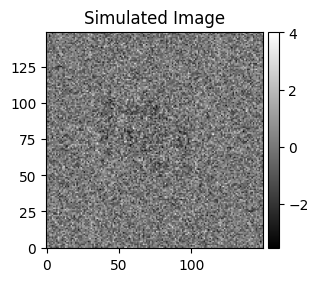

In [32]:
import cryojax.ndimage as im
import jax.random as jr


def simulate_fn(particle_parameters, conformational_space, rng_key):
    # Generate RNG keys for each part of the process
    conformation_rng_key, noise_rng_key, snr_rng_key = jr.split(rng_key, 3)
    # Build image model, including normalization within a circular mask
    # around each particle
    image_config, pose, transfer_theory = (
        particle_parameters["image_config"],
        particle_parameters["pose"],
        particle_parameters["transfer_theory"],
    )
    mask = im.CircularCosineMask(
        coordinate_grid=image_config.get_coordinate_grid(physical=True),
        radius=150.0,
        rolloff_width=0.0,
        xy_offset=pose.offset_in_angstroms,
    )
    volume = DiscreteConformationSampler(
        conformation_rng_key, conformational_space, weights=(0.5, 0.5)
    )
    image_model = cxs.make_image_model(
        volume,
        pose=pose,
        image_config=image_config,
        transfer_theory=transfer_theory,
        normalizes_signal=True,
        signal_region=mask.get() == 1.0,
    )
    # Build noise model at a randomly sampled SNR within a
    # uniform range, then simulate
    snr = jax.random.uniform(snr_rng_key, minval=0.01, maxval=0.1)
    noise_model = cxs.GaussianWhiteNoiseModel(
        image_model,
        variance=1.0,
        signal_scale_factor=jnp.sqrt(snr),
    )

    return noise_model.sample(rng_key=noise_rng_key)


# Simulate a test image
fig, ax = plt.figure(figsize=(3, 3)), plt.gca()
test_parameters = parameter_file[0]
image = simulate_fn(test_parameters, conformational_space, rng_key=jax.random.key(1234))
plot_image(image, fig, ax, label="Simulated Image")

Finally, simulate a dataset using [`cryospax.simulate_particle_stack`][].

!!! info "The `simulate_particle_stack` tool"
    This function takes in two key arguments: a STAR file and a function
    that simulates images. We just defined the latter, but we also need
    build off of the `RelionParticleParameterFile` we defined and build what
    is called a `RelionParticleDataset`. This specifies how to write
    the MRC files.

In [33]:
import pathlib


# Instantiate MRC I/O via the `RelionParticleDataset`
path_to_relion_project = "./outputs/"
mrcfile_output_folder = "images/"
path_to_mrcfiles = pathlib.Path(path_to_relion_project, mrcfile_output_folder)
if not path_to_mrcfiles.exists():
    path_to_mrcfiles.mkdir(parents=True, exist_ok=False)

dataset = spx.RelionParticleDataset(
    parameter_file,
    path_to_relion_project=path_to_relion_project,
    mode="w",
    mrcfile_settings={"overwrite": True, "output_folder": mrcfile_output_folder},
)

Finally, let's use `simulate_particle_stack` to simulate images. 

In [34]:
rng_keys = jax.random.split(jax.random.key(seed=1234), num=len(dataset))
spx.simulate_particle_stack(
    dataset,
    simulate_fn,
    constant_args=conformational_space,
    per_particle_args=rng_keys,
    batch_size=10,  # how many images to simulate in parallel
    images_per_file=50,  # how many images in each MRC file
    overwrite=True,
)

ValueError: Non-hashable static arguments are not supported. An error occurred while trying to hash an object of type <class 'tuple'>, (((<function _configure_simulation_fn.<locals>.simulate_batch_fn at 0x152eb9b3e5c0>,), PyTreeDef(*)), ((150, 150, None, None, 200, 200, 'none',    rlnImageName
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12          NaN
13          NaN
14          NaN
15          NaN
16          NaN
17          NaN
18          NaN
19          NaN
20          NaN
21          NaN
22          NaN
23          NaN
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
30          NaN
31          NaN
32          NaN
33          NaN
34          NaN
35          NaN
36          NaN
37          NaN
38          NaN
39          NaN
40          NaN
41          NaN
42          NaN
43          NaN
44          NaN
45          NaN
46          NaN
47          NaN
48          NaN
49          NaN, None, None, None, None, None, None, None, None, None, None), PyTreeDef({'image_config': CustomNode(BasicImageConfig[(<equinox._module._flatten._Missing object at 0x152fe4176090>,)], [(*, *), *, *, {'shape': (*, *)}, *, None]), 'metadata': *, 'pose': CustomNode(EulerAnglePose[(<equinox._module._flatten._Missing object at 0x152fe4176090>,)], [*, *, *, *]), 'transfer_theory': CustomNode(ContrastTransferTheory[(<equinox._module._flatten._Missing object at 0x152fe4176090>,)], [CustomNode(AstigmaticCTF[(<equinox._module._flatten._Missing object at 0x152fe4176090>,)], [*, *, *, *]), None, *, *])})), ((None, None, None, None, None, None, None), PyTreeDef((((CustomNode(GaussianMixtureVolume[(<equinox._module._flatten._Missing object at 0x152fe4176090>,)], [*, *, *]), CustomNode(GaussianMixtureVolume[(<equinox._module._flatten._Missing object at 0x152fe4176090>,)], [*, *, *])), *, None), {})))). The error was:
TypeError: unhashable type: 'DataFrame'


Finally, as we saw in the [load cryo-EM images](https://michael-0brien.github.io/cryojax/examples/read-dataset/) tutorial, we can load images and parameters using the `RelionParticleDataset`.

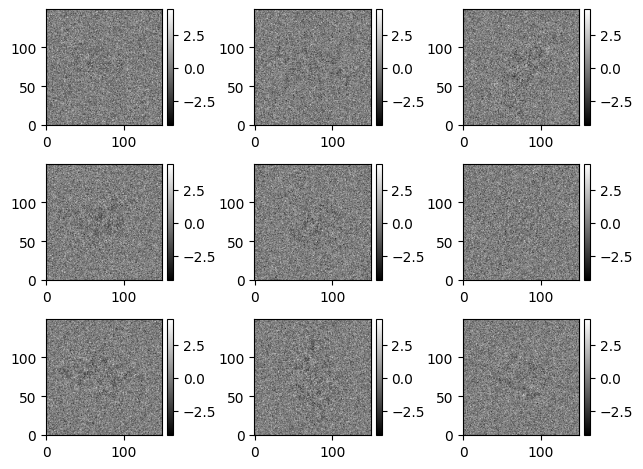

In [9]:
import math


def plot_image_stack(images, cmap="gray", **kwargs):
    n_images_per_side = int(math.sqrt(images.shape[0]))
    fig, axes = plt.subplots(nrows=n_images_per_side, ncols=n_images_per_side)
    vmin, vmax = images.min(), images.max()
    for idx, ax in enumerate(axes.ravel()):
        im = ax.imshow(
            images[idx], cmap=cmap, vmin=vmin, vmax=vmax, origin="lower", **kwargs
        )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax)
    fig.tight_layout()


particles = dataset[0:9]
plot_image_stack(particles["images"])